In [41]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('DE_precincts_updated2.csv')

data = df.dropna()
data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
data.drop(columns=['Hawkins Percentage','Jorgensen Percentage'], inplace=True)

data['ETH1_OTHERS'] = data['POPULATION'] - data['ETH1_EUR'] - data['ETH1_AA']
data['pct_caucasian'] = data['ETH1_EUR'] / data['POPULATION']
data['pct_africanamerican'] = data['ETH1_AA'] / data['POPULATION']
data['pct_other'] = data['ETH1_OTHERS'] / data['POPULATION']

data['Biden Percentage'] = data['Biden Percentage'] / 100
data['Trump Percentage'] = data['Trump Percentage'] / 100
data['Others Percentage'] = 1 - data['Biden Percentage'] - data['Trump Percentage']

data = data.dropna()
rows_with_negative_eth_other = data[data['ETH1_OTHERS'] < 0]
data = data.drop(rows_with_negative_eth_other.index)
data.head()
print(data)

     OBJECTID  DISTRICT  POPULATION   RDED  TOTAL_REG  ETH1_EUR  ETH1_AA  \
42         55         4        1202  04-01       1614      1237       23   
52         65         4        1073  04-11       1416      1102      110   
101       114         8         973  08-07       1272       865      179   
152       165        12         174  12-08        262       207        8   

     Biden Percentage  Trump Percentage  ETH1_OTHERS  pct_caucasian  \
42             0.7407            0.2452          -58       1.029118   
52             0.6382            0.3476         -139       1.027027   
101            0.4559            0.5243          -71       0.889003   
152            0.5904            0.3976          -41       1.189655   

     pct_africanamerican  pct_other  Others Percentage  
42              0.019135  -0.048253             0.0141  
52              0.102516  -0.129543             0.0142  
101             0.183967  -0.072970             0.0198  
152             0.045977  -0.235632

C:\Users\danda\AppData\Local\Temp\ipykernel_16304\1415710196.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_16304\1415710196.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Hawkins Percentage','Jorgensen Percentage'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_16304\1415710196.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,OBJECTID,DISTRICT,POPULATION,RDED,TOTAL_REG,ETH1_EUR,ETH1_AA,Biden Percentage,Trump Percentage,ETH1_OTHERS,pct_caucasian,pct_africanamerican,pct_other,Others Percentage
0,1,1,1602,01-01,1254,211,936,0.9177,0.0646,455,0.131710,0.584270,0.284020,0.0177
1,2,1,1982,01-02,1579,155,1310,0.9469,0.0475,517,0.078204,0.660949,0.260848,0.0056
2,3,1,1692,01-03,1262,83,1094,0.9569,0.0406,515,0.049054,0.646572,0.304374,0.0025
3,4,1,2067,01-04,1619,249,1224,0.9342,0.0545,594,0.120464,0.592163,0.287373,0.0113
4,5,1,2063,01-05,1636,589,826,0.8611,0.1234,648,0.285507,0.400388,0.314106,0.0155


In [42]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(data[['pct_caucasian','pct_africanamerican', 'pct_other']]).T
votes_fractions = np.array(data[['Biden Percentage', 'Trump Percentage','Others Percentage']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

negative_values = group_fractions[group_fractions < 0]
print("Negative values:", negative_values)

candidate_names_rbyc = ['Biden', 'Trump', 'Others']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(data["POPULATION"])
precinct_names = np.array(data['RDED'])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       precinct_names=precinct_names
)


Negative values: []
Running ['Caucasian', 'African American', 'Others'] x ['Biden', 'Trump', 'Others'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 424


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [63]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
#np.set_printoptions(threshold=np.inf)

demographic_group_counts = np.transpose(
            ei_rbyc.demographic_group_fractions * ei_rbyc.precinct_pops
        )
#print(demographic_group_counts)



print(sampled_voting_prefs[:,0,0])

[[[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.574102

array([<Axes: title={'center': 'Support for Biden'}>,
       <Axes: title={'center': 'Support for Trump'}, ylabel='Probability Density'>,
       <Axes: title={'center': 'Support for Others'}>], dtype=object)

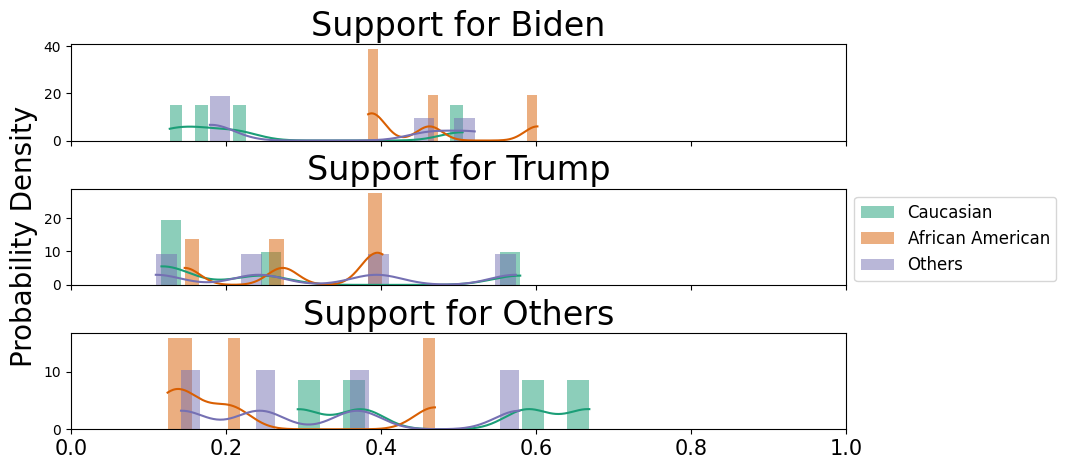

In [44]:
ei_rbyc.plot()

In [64]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Biden", "Trump", "Others"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "DELAWARE",
            "candidate": candidate,
            "race": group,
            "data": data.tolist()  # Converting numpy array to Python list
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [4]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('DE_precincts_updated3.csv')
data = df.dropna()
data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
data['ETH1_OTHERS'] = data['POPULATION'] - data['ETH1_EUR'] - data['ETH1_AA']
data['pct_caucasian'] = data['ETH1_EUR'] / data['POPULATION']
data['pct_africanamerican'] = data['ETH1_AA'] / data['POPULATION']
data['pct_other'] = data['ETH1_OTHERS'] / data['POPULATION']

data['Rochester Percentage'] = data['Rochester Percentage'] / 100
data['Murphy Percentage'] = data['Murphy Percentage'] / 100
data['Others Percentage'] = 1 - data['Rochester Percentage'] - data['Murphy Percentage']

data = data.dropna()
rows_with_negative_eth_other = data[data['ETH1_OTHERS'] < 0]
data = data.drop(rows_with_negative_eth_other.index)
data.head()

C:\Users\danda\AppData\Local\Temp\ipykernel_22456\3176071873.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_22456\3176071873.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ETH1_OTHERS'] = data['POPULATION'] - data['ETH1_EUR'] - data['ETH1_AA']
C:\Users\danda\AppData\Local\Temp\ipykernel_22456\3176071873.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,OBJECTID,DISTRICT,POPULATION,RDED,TOTAL_REG,ETH1_EUR,ETH1_AA,Rochester Percentage,Murphy Percentage,ETH1_OTHERS,pct_caucasian,pct_africanamerican,pct_other,Others Percentage
0,1,1,1602,01-01,1254,211,936,0.9226,0.0696,455,0.131710,0.584270,0.284020,0.0078
1,2,1,1982,01-02,1579,155,1310,0.9452,0.0482,517,0.078204,0.660949,0.260848,0.0066
2,3,1,1692,01-03,1262,83,1094,0.9567,0.0341,515,0.049054,0.646572,0.304374,0.0092
3,4,1,2067,01-04,1619,249,1224,0.9301,0.0551,594,0.120464,0.592163,0.287373,0.0148
4,5,1,2063,01-05,1636,589,826,0.8652,0.1191,648,0.285507,0.400388,0.314106,0.0157


In [5]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(data[['pct_caucasian','pct_africanamerican', 'pct_other']]).T
votes_fractions = np.array(data[['Rochester Percentage', 'Murphy Percentage','Others Percentage']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

negative_values = group_fractions[group_fractions < 0]
print("Negative values:", negative_values)

candidate_names_rbyc = ['Rochester', 'Murphy', 'Others']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(data["POPULATION"])
precinct_names = np.array(data['RDED'])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       precinct_names=precinct_names
)

Negative values: []
Running ['Caucasian', 'African American', 'Others'] x ['Rochester', 'Murphy', 'Others'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 495


C:\Users\danda\PhpstormProjects\cse416-rockets\python_stuff\venv\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'Support for Rochester'}>,
       <Axes: title={'center': 'Support for Murphy'}, ylabel='Probability Density'>,
       <Axes: title={'center': 'Support for Others'}>], dtype=object)

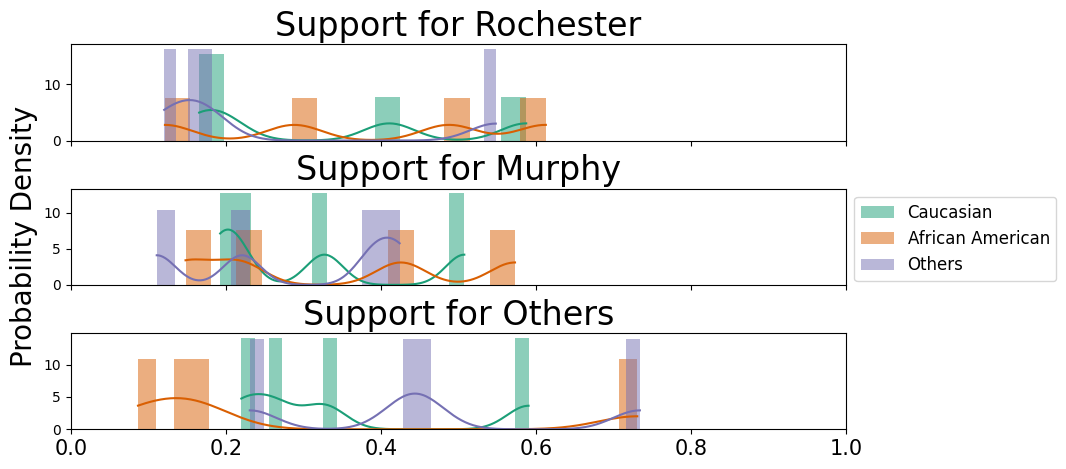

In [6]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
ei_rbyc.plot()

In [8]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Rochester", "Murphy", "Others"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "DELAWARE",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "RepInCongress"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [1]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('AL_ei_data.csv')

df['checksum'] = df['pct_eth1_eur'] + df['pct_eth1_aa'] + df['pct_eth1_other']

tolerance = 1e-8  # Adjust as needed

df[['pct_eth1_eur', 'pct_eth1_aa', 'pct_eth1_other']] = df[['pct_eth1_eur', 'pct_eth1_aa', 'pct_eth1_other']].round(decimals=8)
df = df[df['checksum'] == 1]
df = df[:-99300]

# Find rows where checksum is not approximately equal to 1
df.head()
print(df)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected ! Aesara will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


      Unnamed: 0  total_reg  party_rep  party_dem  eth1_eur  eth1_aa  \
0              0        454        382         42       416        5   
9              9        450        342         82       362       61   
10            10        172         84         73        96       60   
11            11        358        287         43       305       26   
12            12        523        246        245       265      229   
...          ...        ...        ...        ...       ...      ...   
3990        3990          6          0          6         0        6   
3999        3999          8          5          2         6        0   
4000        4000         75         42          9        62        0   
4012        4012          1          0          0         1        0   
4014        4014         25         19          1        24        0   

      party_other  eth1_other  pct_party_rep  pct_party_dem  pct_party_other  \
0              30          33       0.841410       0.09

C:\Users\danda\PhpstormProjects\cse416-rockets\python_stuff\venv\Lib\site-packages\numba\core\decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(df[['pct_eth1_eur','pct_eth1_aa', 'pct_eth1_other']]).T
votes_fractions = np.array(df[['pct_party_dem', 'pct_party_rep','pct_party_other']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

not1values = group_fractions[group_fractions != 1]
not1values2 = votes_fractions[votes_fractions != 1]
print("non1 values:", not1values)
print("non1 VALUES:", not1values2)

candidate_names_rbyc = ['Biden', 'Trump', 'Others']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(df["total_reg"])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       #precinct_names=precinct_names
)


non1 values: [0.9163   0.804444 0.55814  ... 0.173333 0.       0.04    ]
non1 VALUES: [0.092511 0.182222 0.424419 ... 0.125    0.32     0.2     ]
Running ['Caucasian', 'African American', 'Others'] x ['Biden', 'Trump', 'Others'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 2092


C:\Users\danda\PhpstormProjects\cse416-rockets\python_stuff\venv\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'Support for Biden'}>,
       <Axes: title={'center': 'Support for Trump'}, ylabel='Probability Density'>,
       <Axes: title={'center': 'Support for Others'}>], dtype=object)

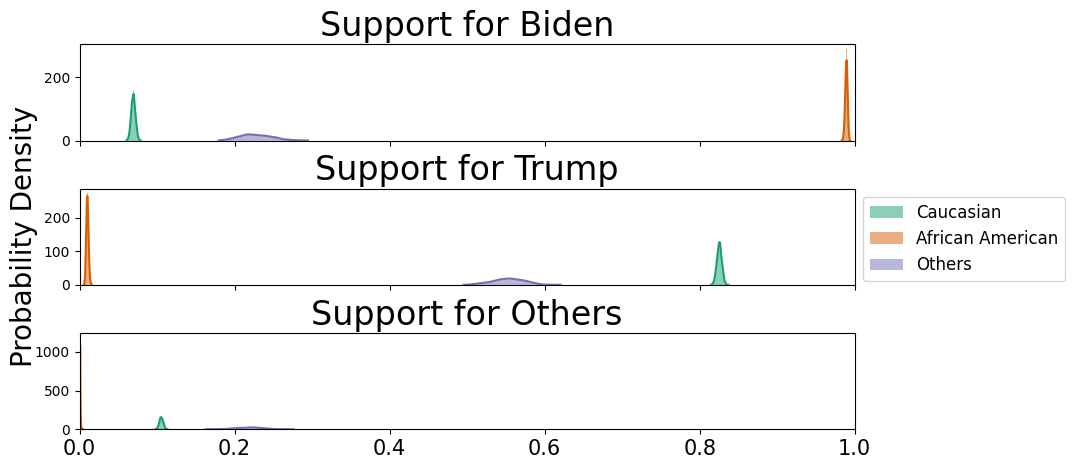

In [3]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
ei_rbyc.plot()

In [4]:
print(sampled_voting_prefs)

[[[6.91675530e-02 8.27416135e-01 1.03416312e-01]
  [9.87714567e-01 1.03337962e-02 1.95163716e-03]
  [2.17627066e-01 5.55702685e-01 2.26670249e-01]]

 [[7.18313805e-02 8.25306767e-01 1.02861852e-01]
  [9.87570528e-01 1.14830926e-02 9.46379679e-04]
  [2.13639391e-01 5.65594194e-01 2.20766415e-01]]

 [[6.63457682e-02 8.29346257e-01 1.04307974e-01]
  [9.89703154e-01 8.91462489e-03 1.38222107e-03]
  [2.14826889e-01 5.53984787e-01 2.31188324e-01]]

 ...

 [[7.71694791e-02 8.21151154e-01 1.01679367e-01]
  [9.88659074e-01 1.07619641e-02 5.78962156e-04]
  [2.02125333e-01 5.62402556e-01 2.35472111e-01]]

 [[7.24110304e-02 8.22479069e-01 1.05109901e-01]
  [9.89358203e-01 9.93482350e-03 7.06973919e-04]
  [1.95598275e-01 5.69586001e-01 2.34815724e-01]]

 [[7.25693214e-02 8.25956079e-01 1.01474600e-01]
  [9.89523313e-01 9.93052258e-03 5.46164645e-04]
  [1.97222839e-01 5.65584570e-01 2.37192591e-01]]]


In [5]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Biden", "Trump", "Others"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "ALABAMA",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "Presidential"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)
